## Federated Learning

There are many examples all over the Internet regarding the use of PyTorch in Federated Learning architectures.

The idea is to use a centralized federated learning, in which a central server organizes the training process. They are responsible for choosing the nodes and aggregating the parameters.

Functions: Train clients models, aggregate parameters, test global model, set clients.

**Resources:**

https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-3-ae2103c40c22

https://www.kaggle.com/code/puru98/federated-learning-pytorch

https://github.com/yonetaniryo/federated_learning_pytorch/blob/master/FL_pytorch.ipynb


In [25]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

The following part is based from the preprocessing process done by Pol Valls in his Bachelor's thesis: 

In [26]:
# Load training datasets and testing datasets 
training1 = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Train-Basic-Part1.csv')
training2 = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Train-Basic-Part2.csv')
training3 = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Train-Basic-Part3.csv')
test_basic = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Test-Basic.csv')
test_plus = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Test+.csv')

C:\Users\UX430\AppData\Local\Temp/ipykernel_2504/701345984.py:2: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  training1 = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Train-Basic-Part1.csv')
C:\Users\UX430\AppData\Local\Temp/ipykernel_2504/701345984.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  training2 = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Train-Basic-Part2.csv')
C:\Users\UX430\AppData\Local\Temp/ipykernel_2504/701345984.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  training3 = pd.read_csv('C:/Users/UX430/Documents/thesis/datasets/UNSW-NB15/UNSW-NB15-Train-Basic-Part3.csv')
C:\Users\UX430\AppData\Local\Temp/ipykernel_2504/701345984.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  

In [129]:
def preprocessing(data): 

    # Select the 'proto' and 'state' values that I want
    data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
    data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] == 'PAR'), :]

    # Extracting dataset labels
    data_labels=data[['label']]

    # Drop the invalid features and select interested data features
    data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

    """PREPROCESSING"""


    # Preprocess IP and ports features
    # IP Source Address
    data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
    data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
    data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))


    # IP Destination Address
    data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
    data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
    data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

    # Ports
    data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
    data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

    # Convert all ports with 0 decimal, and HEX to DEC
    data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
    data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

    data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
    data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

    # Convert field to int format
    data_features['srcip'] = data_features['srcip'].astype(int)
    data_features['sport'] = data_features['sport'].astype(int)
    data_features['dstip'] = data_features['dstip'].astype(int)
    data_features['dsport'] = data_features['dsport'].astype(int)

    # Convert some fields to logarithmic
    log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

    for col in log1p_col:
        data_features[col] = data_features[col].apply(np.log1p)
        
    # Create a complementary field of attack & Transform to One hot encoding - LABELS
    normal=data_labels['label']
    normal=normal.replace(1,2)
    normal=normal.replace(0,1)
    normal=normal.replace(2,0)

    # Insert the new column in data labels
    data_labels.insert(1, 'normal', normal)
    data_labels = pd.get_dummies(data_labels)

    # Transform to One hot encoding - FEATURES
    data_features=pd.get_dummies(data_features)

    # Generate 2 new columns to fit with training
    auxCol=data_features['sbytes']
    auxCol=0
    if data_features.shape[1] == 22: 
        data_features.insert(13, 'proto_igmp', auxCol, True)
        data_features.insert(21, 'state_PAR', auxCol, True)
    elif data_features.shape[1] == 23:
        data_features.insert(21, 'state_PAR', 0, True)

    # Normalize all data features
    data_features = StandardScaler().fit_transform(data_features)

    #Add dimension to data features
    data_features = np.expand_dims(data_features, axis=2)
    data_features = np.expand_dims(data_features, axis=3)

    x = data_features
    y = data_labels

    return x, y

Once we have performed the required steps previous to feeding the data to the model, we need to define said model. The idea is to use a CNN model for the local nodes and use averaging of gradients. 

In [130]:
# Model building and definition
def build_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 1), padding='same'))
    model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(1, 1), padding='same'))
    model.add(layers.Flatten())
    model.add(Dense(444, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    return model 

In [131]:
filepath = 'C:/Users/UX430/Documents/thesis/models/3_nodes_balanced_FL_Try1.hdf5'

callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 10 # Stop after 10 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [132]:
# Define 
node_datasets = [training1, training2, training3]
num_nodes = 3
global_updates = 10

# Define model training parameters
optimizer = keras.optimizers.Adam(learning_rate=5e-4)
loss_fct = "categorical_crossentropy"
metrics = ['accuracy']
local_epochs = 10

In [137]:
def train_local_model(model, x_train, y_train): 
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=metrics)
    history = model.fit(x_train, y_train, epochs=10, validation_split=0.2, callbacks=callbacks, batch_size=2048)
    return model, history.history['loss'], history.history['accuracy']

In [134]:
def aggregate(grad_list):
    avg_grad = [np.mean(grads, axis = 0) for grads in zip(*grad_list)]
    return avg_grad

In [138]:
global_model = build_model((24,1,1))

In [155]:
x_test, y_test = preprocessing(test_basic)

In [140]:
for i in range(global_updates): 
    gradients_list = []
    loss_acc = []
    for node in range(num_nodes): 
        x, y = preprocessing(node_datasets[node])
        cp = global_model # create a copy of the global model
        local_model, loss, accuracy = train_local_model(cp, x, y)
        with tf.GradientTape() as tape: 
            predictions = local_model(x)
            loss = tf.keras.losses.categorical_crossentropy(y, predictions)
        gradients = tape.gradient(loss, local_model.trainable_weights)
        gradients_list.append(gradients)
    avg_grad = aggregate(gradients_list)
    global_model.optimizer.apply_gradients(zip(avg_grad, global_model.trainable_weights)) # apply gradients to global model
    results = global_model.evaluate(x_test, y_test)
    loss_acc.append(results)

Epoch 1/10
54/54 [==============================] - 9s 161ms/step - loss: 0.2641 - accuracy: 0.9724 - val_loss: 2.7183 - val_accuracy: 0.4715
Epoch 2/10
54/54 [==============================] - 8s 155ms/step - loss: 0.0342 - accuracy: 0.9923 - val_loss: 0.8864 - val_accuracy: 0.4914
Epoch 3/10
54/54 [==============================] - 8s 154ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.8381 - val_accuracy: 0.4996
Epoch 4/10
54/54 [==============================] - 8s 153ms/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.4916 - val_accuracy: 0.6999
Epoch 5/10
54/54 [==============================] - 8s 155ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.6602 - val_accuracy: 0.5580
Epoch 6/10
54/54 [==============================] - 8s 155ms/step - loss: 0.0203 - accuracy: 0.9930 - val_loss: 0.6199 - val_accuracy: 0.5856
Epoch 7/10
54/54 [==============================] - 9s 158ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.7106 - val_accuracy: 0.5535
Epoch 

In [141]:
# Save global model 
global_model.save('C:/Users/UX430/Documents/thesis/models/3_nodes_balanced_FL_Try1.hdf5')

In [146]:
# Plot evolution of loss_acc 
results = global_model.evaluate(x_test, y_test)

4279/4279 [==============================] - 26s 6ms/step - loss: 0.0845 - accuracy: 0.9904


In [156]:
x_test_plus, y_test_plus = preprocessing(test_plus)

In [148]:
global_model.evaluate(x_test_plus, y_test_plus)

1721/1721 [==============================] - 9s 5ms/step - loss: 1.1475 - accuracy: 0.8154


[1.1475040912628174, 0.8154109120368958]

Make predictions and create confusion matrix: 

   1/4279 [..............................] - ETA: 2:11

4279/4279 [==============================] - 22s 5ms/step


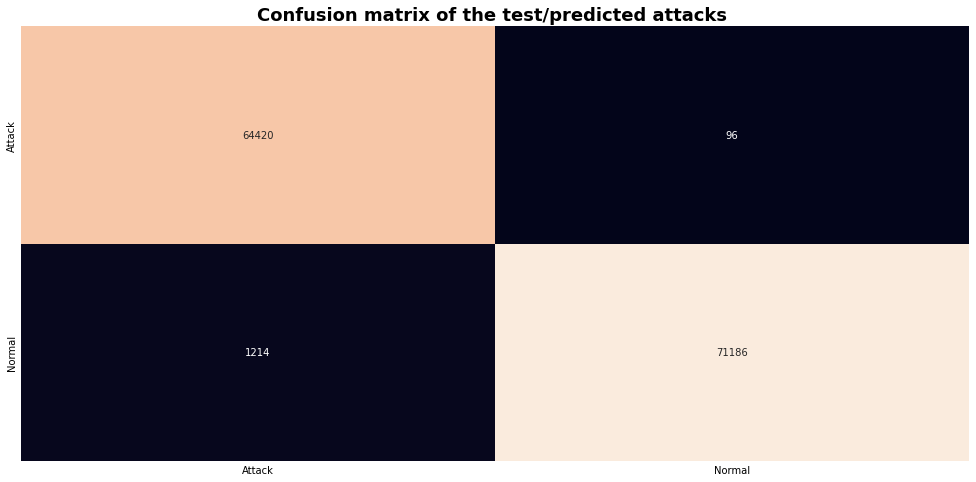

In [157]:
# Prediction
predicted = global_model.predict(x_test)

# Confusion matrix
y_class1 = np.argmax(predicted, axis = 1) 
y_test=y_test.to_numpy()
y_check1 = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check1, y_class1)

cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.figure(figsize=(17,8))
plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
plt.show()

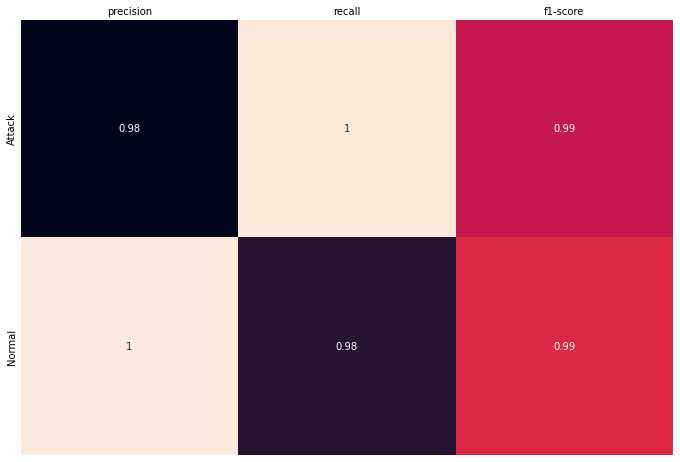

In [158]:
# Precision, Recall & F1-Score
plt.figure(figsize=(15,8))
class_rep = classification_report(y_check1, y_class1, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=False, annot=True)
plt.show()

   1/1721 [..............................] - ETA: 1:14

1721/1721 [==============================] - 10s 6ms/step


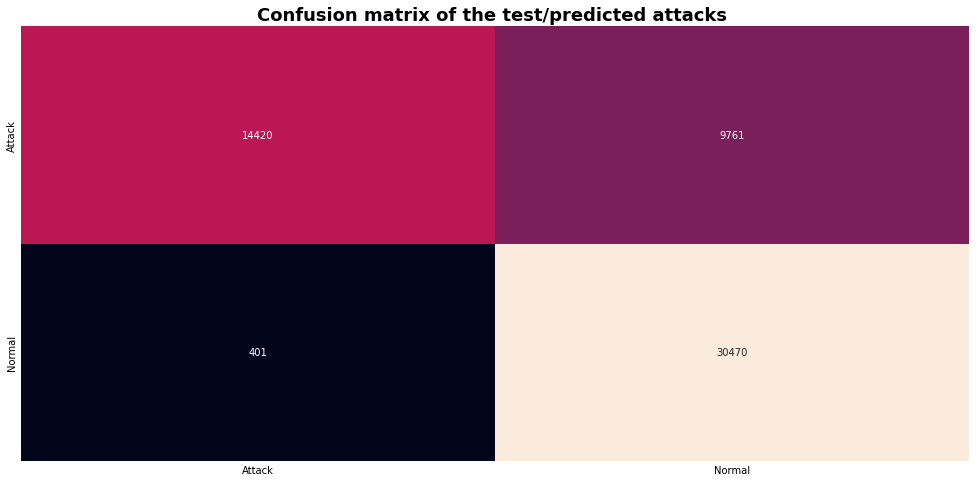

In [159]:
# Prediction
predicted = global_model.predict(x_test_plus)

# Confusion matrix
y_class2 = np.argmax(predicted, axis = 1) 
y_test_plus=y_test_plus.to_numpy()
y_check2 = np.argmax(y_test_plus, axis = 1) 

cmatrix = confusion_matrix(y_check2, y_class2)

cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.figure(figsize=(17,8))
plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
plt.show()

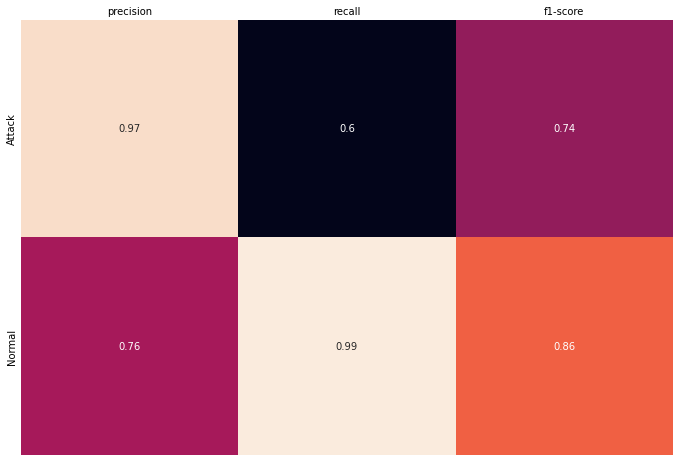

In [160]:
# Precision, Recall & F1-Score
plt.figure(figsize=(15,8))
class_rep = classification_report(y_check2, y_class2, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=False, annot=True)
plt.show()